Implementing Evaluators
=======================

[Evaluators](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Evaluator) represent the process of estimating performance indicators within Hermes' API, both during simulation runtime and in custom use-cases.
They are, arguably, one of the more complex concepts to grasp for library users not very accustomed to distributed computing.

In order to demonstrate the programming workflow, we'll add an evaluator estimating the average signal power received at a wireless device.
Such an tool could be useful to gain insight into the behaviour of beamformers in multipath environments, or simply as a debugging tool of channel models and waveforms.
Let's get right into it:

In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from hermespy.core import Artifact, Device, Evaluation, EvaluationResult, Evaluator, Executable, GridDimension
    

class PowerArtifact(Artifact):
    
    power: float
    
    def __init__(self, power: float) -> None:
        
        self.power = power
        
    def __str__(self) -> str:
        
        return f"{self.power:.2f}"
    
    def to_scalar(self) -> float:
        
        return self.power
    

class PowerEvaluation(Evaluation):
    
    power: np.ndarray
    
    def __init__(self, device: Device) -> None:
        
        received_signal = device.received_signal
        
        if received_signal is None:
            raise RuntimeError("Device has not received a signal yet")
        
        self.power = received_signal.power
        
    def plot(self) -> None:
        
        with Executable.style_context():
            
            fig, axis = plt.subplots()
            fig.suptitle('Received Signal Powers')
            
            axis.stem(np.arange(len(self.power)), self.power)
            axis.set_xlabel('Antenna Index')
            axis.set_ylabel('Power')
            
    def artifact(self) -> PowerArtifact:
        
        summed_power = np.sum(self.power, keepdims=False)
        return PowerArtifact(summed_power)


class PowerEvaluationResult(EvaluationResult):
    
    def __init__(self, grid: List[GridDimension], artifacts: np.ndarray) -> None:
    
        self.grid = grid
        
        self.artifacts = np.empty(artifacts.shape, dtype=float)
        for section_coords in np.ndindex(artifacts.shape):
            self.artifacts[section_coords] = np.mean([a.power for a in artifacts[section_coords]])
        
    def plot(self) -> plt.Figure:
        
        with Executable.style_context():
            
            fig = plt.figure()
            fig.suptitle('Power Evaluation Result')
            self._plot_multidim(self.grid, self.artifacts, 0, 'Average Power', 'linear', 'linear', fig)
            
            return fig
        
    def to_array(self) -> np.ndarray:
        
        return self.artifacts


class PowerEstimator(Evaluator):
    
    def __init__(self, device: Device) -> None:
        
        self.__device = device
        Evaluator.__init__(self)
        
    def evaluate(self) -> PowerEvaluation:
        
        return PowerEvaluation(self.__device)
    
    @property
    def abbreviation(self) -> str:
        
        return "Power"
    
    @property
    def title(self) -> str:
        
        return "Received Power"
    
    def generate_result(self, grid: List[GridDimension], artifacts: np.ndarray) -> PowerEvaluationResult:
        
        return PowerEvaluationResult(grid, artifacts)

Here's what you're probably thinking right now: [Artifacts](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Artifact), [Evaluations](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Evaluation), [EvaluationResults](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.EvaluationResult) and [Evaluators](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Evaluator), why do we need four interacting classes to investigate a single performance indicator?
The answer is, this structure is required to enable efficient distributed execution of Monte Carlo simulations, while simulatenously offering an easily programmable interface for other use-cases such as software defined radio operation.

The basis is the [Evaluator](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Evaluator), in our case the  *PowerEstimator*.
Given a single scenario data drop, it generates an [Evaluation](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Evaluation) object representing the extracted performance indicator information.
This information is then compressed to Artifacts [Artifacts](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Artifact) for each simulation grid sample and finally collected within the [generate_result](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Evaluator.generate_result) method of the [Evaluator](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Evaluator), creating an [EvaluationResult](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.EvaluationResult).

During distributed simulations, the process of generating [Artifacts](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.Artifact) is executed multiple times in parallel, with only the resulting artifacts being sent to the simulation controller, in order to optimize the simulation data throughput between simulation controller and distributed simulation workers.
Hermes is built around the [Ray](https://www.ray.io/), with optimizations like this Monte Carlo simulations become "embarassingly parallel" and, as a consequence, blazingly fast on multicore systems.

We can now define the simulation scenario of a two-device $5 \times 5$ MIMO simplex link transmitting an OFDM waveform over an ideal channel.
Within a Monte Carlo simulation, we sweep the channel gain and observe the effect on the received signal power by our newly created Estimator:

In [2]:
import matplotlib.pyplot as plt

from hermespy.core import UniformArray, IdealAntenna
from hermespy.modem import SimplexLink, ElementType, FrameElement, FrameResource, FrameSymbolSection, OFDMWaveform
from hermespy.precoding import SpatialMultiplexing
from hermespy.simulation import Simulation

# Create a new Monte Carlo simulation
simulation = Simulation()

# Configure a simplex link between a transmitting and receiving device, interconnected by an ideal channel
operator = SimplexLink(simulation.new_device(antennas=UniformArray(IdealAntenna, 1e-2, [5, 1, 1])),
                       simulation.new_device(antennas=UniformArray(IdealAntenna, 1e-2, [5, 1, 1])))

# Configure an OFDM waveform with a frame consisting of a single symbol section
operator.waveform_generator = OFDMWaveform(resources=[FrameResource(elements=[FrameElement(ElementType.DATA, 1200)])],
                                           structure=[FrameSymbolSection(pattern=[0])])
operator.precoding[0] = SpatialMultiplexing()

# Configure a sweep over the linking channel's gain
simulation.new_dimension('gain',
                         np.linspace(0, 1, 11, endpoint=True),
                         simulation.scenario.channel(operator.transmitting_device, operator.receiving_device))

# Configure our custom power evaluator
power_estimator = PowerEstimator(operator.receiving_device)
simulation.add_evaluator(power_estimator)

# Run the simulation
result = simulation.run()

──────────────────────────────────── Simulation Campaign ────────────────────────────────────

[20:54:30] Launched simulation campaign with 24 dedicated actors          ]8;id=770872;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=427327;file://D:\hermespy\hermespy\core\monte_carlo.py#1720\1720]8;;\

           Generating a maximum of 1100 = 100 x 11 samples inspected by 1 ]8;id=842360;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=737865;file://D:\hermespy\hermespy\core\monte_carlo.py#1740\1740]8;;\
           evaluators                                                                        
                                                                                             

Simulation Grid                                                        
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Dimension ┃ Sections                                                ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gain      │ 0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00  │
└───────────┴─────────────────────────────────────────────────────────┘

Output()

Output()

[20:54:43] Simulation finished after 13.14 seconds                        ]8;id=960594;file://D:\hermespy\hermespy\core\monte_carlo.py\monte_carlo.py]8;;\:]8;id=377596;file://D:\hermespy\hermespy\core\monte_carlo.py#1881\1881]8;;\

The simulation routine automatically distributes the workload to all detected CPU cores within the system (in this case $24$) and generates *PowerArtifact* objects in parallel.
Once the simulation is finished, a single *PowerEvaluationResult* is generated and stored within a [MonteCarloResult](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.MonteCarloResult) returned by the simulation [run](../api/simulation.simulation.rst#hermespy.simulation.simulation.Simulation.run) method.

Calling the result's [plot](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.MonteCarloResult.plot) method will then internally call the evaluation result's [plot](../api/core.monte_carlo.rst#hermespy.core.monte_carlo.EvaluationResult.plot), resulting in the following performance indicator visualization:

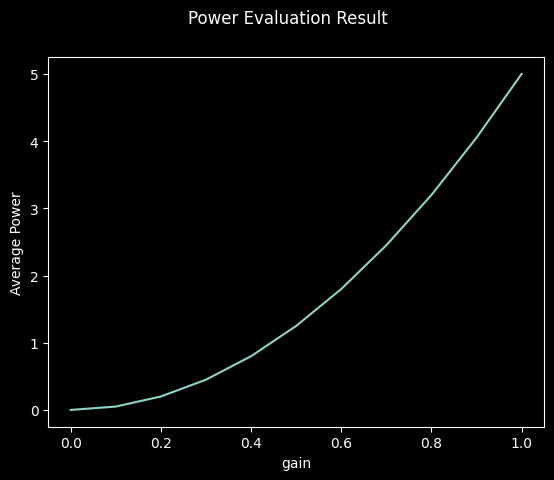

In [3]:
result.plot()
plt.show()

Now while this renders the average power over a number of samples within a simulation, the [Hardware Loop](../api/hardware_loop.rst) has a feature representing performance indicator information in real time during data collection.

This is internally realized by calling the plot funtion of evaluations generated by evaluators, before they are being compressed to artifacts. 
We can demonstrate the output in our current simulation scenario by generating a single drop and calling the evaluator:

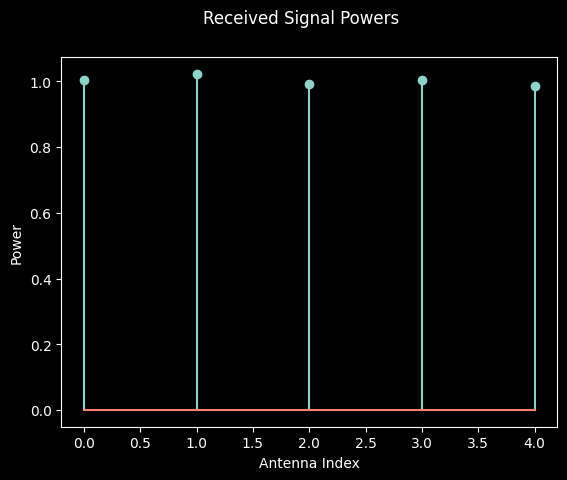

Exception in thread 2022-12-08 23:27:15,626	ERROR worker.py:813 -- print_logs: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Stream removed"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:49322 {grpc_message:"Stream removed", grpc_status:2, created_time:"2022-12-08T22:27:15.621707663+00:00"}"
>
ray_listen_error_messages:
Traceback (most recent call last):
  File "C:\Users\Stealth\AppData\Local\Programs\Python\Python3912\lib\threading.py", line 980, in _bootstrap_inner
2022-12-08 23:27:15,630	ERROR import_thread.py:76 -- ImportThread: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Stream removed"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:49322 {grpc_message:"Stream removed", grpc_status:2, created_time:"2022-12-08T22:27:15.621687705+00:00"}"
>
    self.run()
  File "C:\Users\Stealth\AppData\Local\Programs\Python\Python3912\lib\threading.

In [4]:
_ = simulation.scenario.drop()

power_estimator.evaluate().plot()
plt.show()